In [101]:
# load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

def ler_csv(caminho_arquivo):
    return pd.read_csv(caminho_arquivo, sep=',',usecols=[0,1], decimal=',', header=0)

df = ler_csv('dados/ibovespa.csv')

In [103]:
def df_tratamento_dados(df):
    df = df.rename(columns={'Data':'data','Último': 'value'})
    df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')
    df = df.sort_values(by='data')
    # Completando dados
    # Crie um novo DataFrame com um intervalo completo de datas
    data_inicio = df['data'].min()  # Data de início
    data_fim = df['data'].max()  
    datas_completas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
    # Crie um novo DataFrame com o intervalo completo de datas
    df_completo = pd.DataFrame(datas_completas, columns=['data'])# Faça um merge com o dataframe original

    df = df_completo.merge(df, on='data', how='left')
    df = df.sort_values(by='data')

    
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df.index = pd.to_datetime(df['data'])
    # Interpolação linear
    df['value'] = df['value'].interpolate(method='linear')
    df.set_index('data', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    df = df.asfreq('D')
    return df

In [151]:
data = df_tratamento_dados(df)
#data = data.loc['2016-01-01':'2019-01-08']
data

,value
data,
2010-01-04,70.045
2010-01-05,70.240
2010-01-06,70.729
2010-01-07,70.451
2010-01-08,70.263
...,...
2023-12-24,133.143
2023-12-25,133.338
2023-12-26,133.533


<AxesSubplot:xlabel='data'>

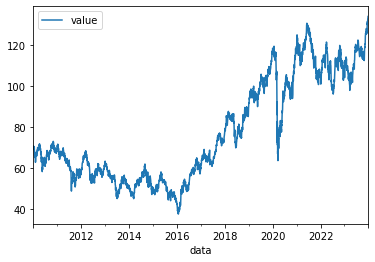

In [105]:
data.plot()

In [106]:
data.head()

,value
data,
2010-01-04,70.045
2010-01-05,70.240
2010-01-06,70.729
2010-01-07,70.451
2010-01-08,70.263


In [107]:
# scale the data
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler(feature_range=(0,1))
data = scale.fit_transform(data)

In [108]:
# divide the data into number of steps 
def create_data(data, seq_len):
    N = len(data)
    X = []
    Y = []
    for i in range(N-seq_len-1):
        x = data[i:i+seq_len]
        X.append(x)
        y = data[i+seq_len]
        Y.append(y)
        
    return X,Y

In [109]:
x,y = create_data(data,50)

In [110]:
# convert the x and y values into arrays
x, y = np.asarray(x), np.asarray(y)

In [111]:
x.reshape(-1,50).shape

(5056, 50)

In [112]:
# divide the data into train and test
def split_data(x,y, ratio):
    assert len(x)==len(y)
    N = len(x)
    train_x, test_x  = x[:int(N*ratio)], x[int(N*ratio):]
    train_y, test_y  = y[:int(N*ratio)], y[int(N*ratio):]
    return train_x,train_y, test_x, test_y

In [113]:
train_x,train_y, test_x, test_y = split_data(x,y,0.8)

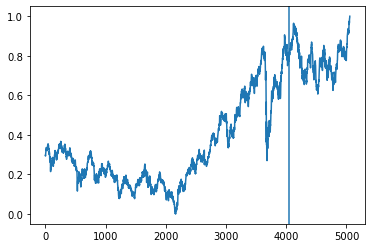

In [114]:
plt.plot(np.vstack((train_y,test_y)))
plt.axvline(int(len(x)*0.8))

In [115]:
# Implement the RNN 
class Simple_RNN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        
        # define the dimensions
        self.in_dim = in_dim
        self.hid_dim = in_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        # define the rnn layer
        self.rnn = nn.RNN(self.in_dim, self.hid_dim, self.layer, nonlinearity='tanh', batch_first=True)
        
        # define fully connected layer for output
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        
        # initialize the hidden layer
        h0 = torch.zeros(self.layer, x.size(0),self.hid_dim)
        
        #initialize the rnn
        out, _ = self.rnn(x,h0)
        
        out = self.fc(out[:,-1,:])
        return out

In [116]:
# convert the data from numpy to tensor
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
test_x = torch.from_numpy(test_x.astype(np.float32))
test_y = torch.from_numpy(test_y.astype(np.float32))

In [117]:
x.shape

(5056, 50, 1)

In [118]:
# define the network
in_size = x.shape[-1]
out_size = in_size
hid_size = 3
num_layers = 1

model = Simple_RNN(in_size,hid_size,out_size, num_layers)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fun = nn.MSELoss()

In [119]:
def train_model(model,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               epochs=500):
    
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred = model(x_train)
        
        # calculate the loss 
        error = criterion(pred,y_train)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()
        
        # save the losses 
        train_loss[epoch] = error.item()
        
        # test loss 
        test_pred = model(x_test)
        test_error = criterion(y_test,test_pred)
        test_loss[epoch] = test_error.item()
        
        if (epoch+1) % 5 ==0:
            print('Epoch :{}    Train Loss :{}    Test Loss :{}'.format((epoch+1)/epochs, error.item(), test_error.item()))
            
    return train_loss, test_loss

In [120]:
train_loss, test_loss = train_model(model,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=500)

Epoch :0.01    Train Loss :0.22937405109405518    Test Loss :0.9453328251838684
Epoch :0.02    Train Loss :0.15060080587863922    Test Loss :0.7252202033996582
Epoch :0.03    Train Loss :0.1027434915304184    Test Loss :0.5631142854690552
Epoch :0.04    Train Loss :0.07566948980093002    Test Loss :0.4485248029232025
Epoch :0.05    Train Loss :0.061418209224939346    Test Loss :0.3690056800842285
Epoch :0.06    Train Loss :0.05457108095288277    Test Loss :0.31477653980255127
Epoch :0.07    Train Loss :0.05158182606101036    Test Loss :0.27902576327323914
Epoch :0.08    Train Loss :0.050239063799381256    Test Loss :0.25691577792167664
Epoch :0.09    Train Loss :0.04935373738408089    Test Loss :0.24473418295383453
Epoch :0.1    Train Loss :0.04847235232591629    Test Loss :0.23944254219532013
Epoch :0.11    Train Loss :0.04755519703030586    Test Loss :0.23850922286510468
Epoch :0.12    Train Loss :0.04669921472668648    Test Loss :0.2398843765258789
Epoch :0.13    Train Loss :0.04597

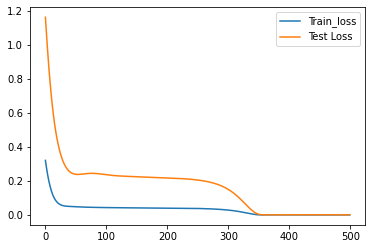

In [121]:
plt.plot(train_loss,label='Train_loss')
plt.plot(test_loss,label='Test Loss')
plt.legend()

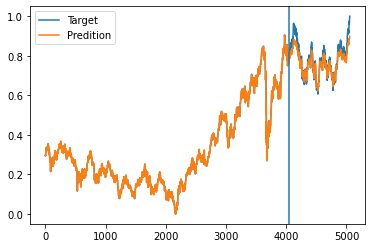

In [122]:
# testing the prediction quality if the trained model
# 1) Multi Step prediction
#plt.plot(train_y.detach().numpy())
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),model(test_x).detach().numpy())),label='Predition')
plt.axvline(int(len(x)*0.8))
plt.legend()

In [123]:
# testing the predction model on multiple time series
last_x = train_x[-1].view(50)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = model(last_x.view(1,50,1))
    prediction_val.append(prediction[0,0].item())
    
    
    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))

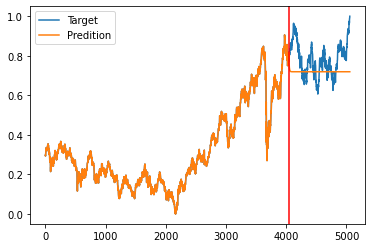

In [124]:
# plot the result
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),np.asarray(prediction_val).reshape(-1,1))),label='Predition')
plt.axvline(int(len(x)*0.8),color='red')
plt.legend()

In [125]:
# Implement LSTM
class LSTM(nn.Module):
    def __init__(self,in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.lstm = nn.LSTM(self.in_dim, self.hid_dim, self.layer, batch_first=True)
        
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        
        # initialize the hidden state
        h0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        c0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        
        # forward propagate
        out, (h_,c_) = self.lstm(x,(h0,c0))
        
        out = self.fc(out[:,-1,:])
        return out

In [126]:
# define the network
in_size = x.shape[-1]
out_size = in_size
hid_size = 5
num_layers = 1

lstm = LSTM(in_size,hid_size,out_size, num_layers)

optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01)
loss_fun = nn.MSELoss()

In [127]:
train_loss, test_loss = train_model(lstm,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=500)

Epoch :0.01    Train Loss :0.05227271467447281    Test Loss :0.2861681580543518
Epoch :0.02    Train Loss :0.04748154804110527    Test Loss :0.18049579858779907
Epoch :0.03    Train Loss :0.045048292726278305    Test Loss :0.17581473290920258
Epoch :0.04    Train Loss :0.03933010250329971    Test Loss :0.1995515078306198
Epoch :0.05    Train Loss :0.03597521781921387    Test Loss :0.20347639918327332
Epoch :0.06    Train Loss :0.027949586510658264    Test Loss :0.14559218287467957
Epoch :0.07    Train Loss :0.01328947301954031    Test Loss :0.07685516029596329
Epoch :0.08    Train Loss :0.006637196522206068    Test Loss :0.022858913987874985
Epoch :0.09    Train Loss :0.0074002500623464584    Test Loss :0.010695732198655605
Epoch :0.1    Train Loss :0.0037103393115103245    Test Loss :0.011151406913995743
Epoch :0.11    Train Loss :0.00414405670017004    Test Loss :0.01250964030623436
Epoch :0.12    Train Loss :0.002408400410786271    Test Loss :0.009992273524403572
Epoch :0.13    Trai

Epoch :0.98    Train Loss :0.00015389772306662053    Test Loss :0.00029407715192064643
Epoch :0.99    Train Loss :0.00015324768901336938    Test Loss :0.00029206695035099983
Epoch :1.0    Train Loss :0.00015260618238244206    Test Loss :0.00029009507852606475


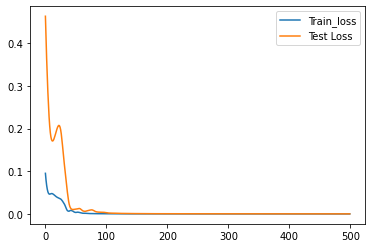

In [128]:
plt.plot(train_loss,label='Train_loss')
plt.plot(test_loss,label='Test Loss')
plt.legend()

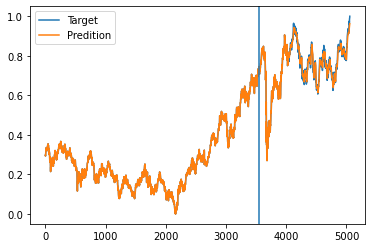

In [129]:
# testing the prediction quality if the trained model
# 1) Multi Step prediction
#plt.plot(train_y.detach().numpy())
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),lstm(test_x).detach().numpy())),label='Predition')
plt.axvline(int(len(x)*0.7))
plt.legend()

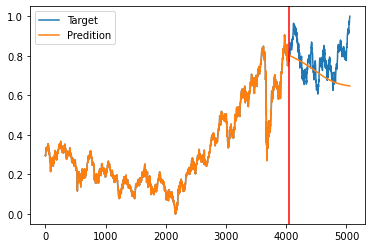

In [130]:
# testing the predction model on multiple time series
last_x = train_x[-1].view(50)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = lstm(last_x.view(1,50,1))
    prediction_val.append(prediction[0,0].item())
    
    
    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))
    
# plot the result
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),np.asarray(prediction_val).reshape(-1,1))),label='Predition')
plt.axvline(int(len(x)*0.8),color='red')
plt.legend()

In [131]:
# implement GRU
class GRU(nn.Module):
    def __init__(self,in_dim, hid_dim, out_dim, num_layer):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.gru = nn.GRU(self.in_dim, self.hid_dim, self.layer, batch_first=True)
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        
        # initalize the hidden layers
        h0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        
        out, _ = self.gru(x,h0)
        out = self.fc(out[:,-1,:])
        return out

In [132]:
# define the network
in_size = x.shape[-1]
out_size = in_size
hid_size = 5
num_layers = 1

gru = GRU(in_size,hid_size,out_size, num_layers)

optimizer = torch.optim.Adam(gru.parameters(), lr=0.01)
loss_fun = nn.MSELoss()

In [133]:
train_loss, test_loss = train_model(gru,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=500)

Epoch :0.01    Train Loss :0.04194968566298485    Test Loss :0.2000616043806076
Epoch :0.02    Train Loss :0.04081207513809204    Test Loss :0.14619195461273193
Epoch :0.03    Train Loss :0.03418228030204773    Test Loss :0.17214159667491913
Epoch :0.04    Train Loss :0.03076816536486149    Test Loss :0.1719433069229126
Epoch :0.05    Train Loss :0.024700386449694633    Test Loss :0.11816136538982391
Epoch :0.06    Train Loss :0.017530879005789757    Test Loss :0.06972943991422653
Epoch :0.07    Train Loss :0.007617257069796324    Test Loss :0.036161158233881
Epoch :0.08    Train Loss :0.00037858181167393923    Test Loss :0.0010805826168507338
Epoch :0.09    Train Loss :0.0031590943690389395    Test Loss :0.00485414732247591
Epoch :0.1    Train Loss :0.00044627036550082266    Test Loss :0.0005494449869729578
Epoch :0.11    Train Loss :0.00041821569902822375    Test Loss :0.003802691586315632
Epoch :0.12    Train Loss :0.0006496544810943305    Test Loss :0.004551392048597336
Epoch :0.13

Epoch :0.98    Train Loss :8.977965626399964e-05    Test Loss :0.0002201592142228037
Epoch :0.99    Train Loss :8.964275912148878e-05    Test Loss :0.0002191596431657672
Epoch :1.0    Train Loss :8.950741175794974e-05    Test Loss :0.00021817277593072504


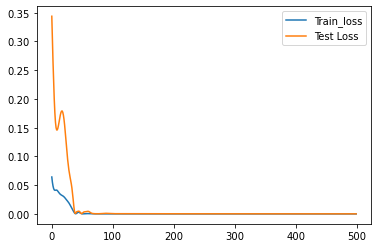

In [137]:
plt.plot(train_loss,label='Train_loss')
plt.plot(test_loss,label='Test Loss')
plt.legend()

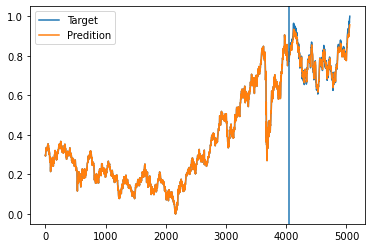

In [138]:
# testing the prediction quality if the trained model
# 1) Multi Step prediction
#plt.plot(train_y.detach().numpy())
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),gru(test_x).detach().numpy())),label='Predition')
plt.axvline(int(len(x)*0.8))
plt.legend()

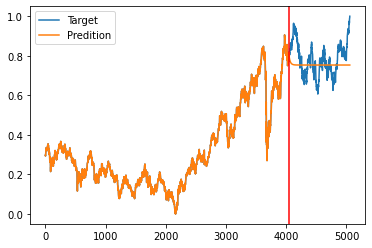

In [141]:
# testing the predction model on multiple time series
last_x = train_x[-1].view(50)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = gru(last_x.view(1,50,1))
    prediction_val.append(prediction[0,0].item())
    
    
    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))
    
# plot the result
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),np.asarray(prediction_val).reshape(-1,1))),label='Predition')
plt.axvline(int(len(x)*0.8),color='red')
plt.legend()

In [144]:
# Implement Autoregressive model
auto_reg = nn.Linear(50,1)
optimizer = torch.optim.Adam(auto_reg.parameters(), lr=0.01)
loss_fun = nn.MSELoss()

In [145]:
train_loss, test_loss = train_model(auto_reg,
               loss_fun,
               optimizer,
               train_x.reshape(-1,50),
               test_x.reshape(-1,50),
               train_y.reshape(-1,1),
               test_y.reshape(-1,1),
               epochs=500)

Epoch :0.01    Train Loss :0.03143233060836792    Test Loss :0.22147499024868011
Epoch :0.02    Train Loss :0.025298090651631355    Test Loss :0.017015604302287102
Epoch :0.03    Train Loss :0.02529866248369217    Test Loss :0.140407994389534
Epoch :0.04    Train Loss :0.0055265468545258045    Test Loss :0.005584199447184801
Epoch :0.05    Train Loss :0.012613319791853428    Test Loss :0.033461932092905045
Epoch :0.06    Train Loss :0.0020682381000369787    Test Loss :0.006682153791189194
Epoch :0.07    Train Loss :0.00604581693187356    Test Loss :0.020613986998796463
Epoch :0.08    Train Loss :0.0021843265276402235    Test Loss :0.0042509292252361774
Epoch :0.09    Train Loss :0.0025812534149736166    Test Loss :0.00224900315515697
Epoch :0.1    Train Loss :0.0023871413432061672    Test Loss :0.007881037890911102
Epoch :0.11    Train Loss :0.0015655740862712264    Test Loss :0.00195513223297894
Epoch :0.12    Train Loss :0.0017836987972259521    Test Loss :0.0020148546900600195
Epoch

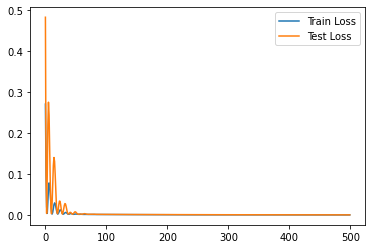

In [146]:
# plot the loss
plt.plot(train_loss,label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend();

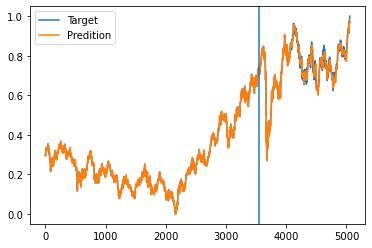

In [148]:
# testing the prediction quality if the trained model
# 1) Multi Step prediction
#plt.plot(train_y.detach().numpy())
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),auto_reg(test_x.reshape(-1,50)).detach().numpy())),label='Predition')
plt.axvline(int(len(x)*0.7))
plt.legend()

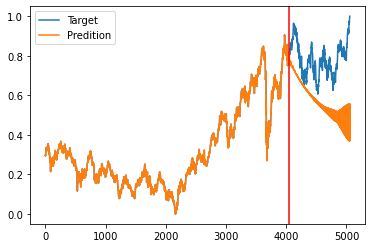

In [150]:
# testing the predction model on multiple time series
last_x = train_x[-1].view(50)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = auto_reg(last_x.view(1,50))
    prediction_val.append(prediction[0,0].item())
    
    
    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))
    
# plot the result
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),np.asarray(prediction_val).reshape(-1,1))),label='Predition')
plt.axvline(int(len(x)*0.8),color='red')
plt.legend()